In [ ]:
import torch
import torch.nn as nn
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from scipy.linalg import sqrtm


from google.colab import drive
drive.mount('/content/gdrive')


if torch.cuda.is_available():
  print("hello GPU")
else:
  print("sadge")


class BaseModel(nn.Module, ABC):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def forward(self, x):
        pass

    @property
    def device(self):
        return next(self.parameters()).device

    def restore_checkpoint(self, ckpt_file, optimizer=None):
        if not ckpt_file:
            raise ValueError("No checkpoint file to be restored.")

        try:
            ckpt_dict = torch.load(ckpt_file)
        except RuntimeError:
            ckpt_dict = torch.load(ckpt_file,
                                   map_location=lambda storage, loc: storage)

        # Restore model weights
        self.load_state_dict(ckpt_dict['model_state_dict'])

        # Restore optimizer status if existing. Evaluation doesn't need this
        if optimizer:
            optimizer.load_state_dict(ckpt_dict['optimizer_state_dict'])

        # Return global step
        return ckpt_dict['global_step']

    def save_checkpoint(self,
                        directory,
                        global_step,
                        optimizer=None,
                        name=None):
        # Create directory to save to
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Build checkpoint dict to save.
        ckpt_dict = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer is not None else None,
            'global_step': global_step
        }

        # Save the file with specific name
        if name is None:
            name = "{}_{}_steps.pth".format(
                os.path.basename(directory),  # netD or netG
                global_step)

        torch.save(ckpt_dict, os.path.join(directory, name))

    def count_params(self):
        num_total_params = sum(p.numel() for p in self.parameters())
        num_trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        return num_total_params, num_trainable_params




class Discriminator(BaseModel):
    def __init__(self, **kwargs):
        super().__init__()
        self.count = 0
        self.errD_array = []
        self.bce = nn.BCELoss()
        self.ndf = 100

        self.sblock1 = nn.Linear(3152,2700)
        self.relu = nn.ReLU(True)
        self.sblock2 = nn.Linear(2700,2000)
        self.sblock3 = nn.Linear(2000,1500)
        self.sblock4 = nn.Linear(1500,1100)
        self.sblock5 = nn.Linear(1100,512)
        self.sblock8 = nn.Linear(512,128)
        self.sblock9 = nn.Linear(128,64)
        self.sblock10 = nn.Linear(64,1)
        self.dropout = nn.Dropout(0.2)

        # Final classification layer
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        h = self.dropout(self.relu(self.sblock1(x)))
        h = self.dropout(self.relu(self.sblock2(h)))
        h = self.dropout(self.relu(self.sblock3(h)))
        h = self.dropout(self.relu(self.sblock4(h)))
        h = self.dropout(self.relu(self.sblock5(h)))
        h = self.dropout(self.relu(self.sblock8(h)))
        h = self.relu(self.sblock9(h))
        h = self.sblock10(h)
        h = self.sigmoid(h)
        return h.view(h.shape[0], 64)

    def compute_loss(self, output, actual):
        return self.bce(output, actual)

def train(open, closed, dupe=False):
  device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
  netD = Discriminator().to(device)
  optimizer = torch.optim.Adam(netD.parameters(), 0.0001, (0.5, 0.99))

  train_lossD = []
  train_accuracyD = []
  test_lossD = []
  test_accuracyD = []

  # Split data into training and testing sets
  train_open, test_open = train_test_split(open, test_size=0.2, random_state=42)
  train_closed, test_closed = train_test_split(closed, test_size=0.2, random_state=42)

  if (dupe):
      train_open = np.concatenate((train_open, train_open))
      train_closed = np.concatenate((train_closed, train_closed))

  # Move data to tensors and to device
  train_open = torch.tensor(train_open).float().to(device)
  train_closed = torch.tensor(train_closed).float().to(device)
  test_open = torch.tensor(test_open).float().to(device)
  test_closed = torch.tensor(test_closed).float().to(device)

  for epoch in range(5):
    # Training
    netD.zero_grad()

    train_output_open = netD.forward(train_open)
    train_output_closed = netD.forward(train_closed)

    train_vals_open = torch.full(train_output_open.shape, 1.0, dtype=torch.float, device=device)
    train_vals_closed = torch.full(train_output_closed.shape, 0.0, dtype=torch.float, device=device)

    train_pred_labels = torch.cat((train_output_open, train_output_closed))
    train_actual_labels = torch.cat((train_vals_open, train_vals_closed))

    train_accuracy = ((train_pred_labels > 0.5) == train_actual_labels).float().mean()
    train_accuracyD.append(train_accuracy.item())

    # Compute training loss
    train_errD_real = netD.compute_loss(train_output_open, train_vals_open)
    train_errD_fake = netD.compute_loss(train_output_closed, train_vals_closed)
    train_errD = train_errD_real + train_errD_fake
    train_errD.backward()
    optimizer.step()

    train_lossD.append(train_errD.item())

    # Testing
    with torch.no_grad():
      test_output_open = netD.forward(test_open)
      test_output_closed = netD.forward(test_closed)

      # Compute classification accuracy
      test_vals_open = torch.full(test_output_open.shape, 1.0, dtype=torch.float, device=device)
      test_vals_closed = torch.full(test_output_closed.shape, 0.0, dtype=torch.float, device=device)

      test_pred_labels = torch.cat((test_output_open, test_output_closed))
      test_actual_labels = torch.cat((test_vals_open, test_vals_closed))

      test_accuracy = ((test_pred_labels > 0.5) == test_actual_labels).float().mean()

      # Bin guess into T/F for confusion matrix
      test_output_open_cm = (test_output_open.mean(dim=1, keepdim=True) > 0.5).float()
      test_output_closed_cm = (test_output_closed.mean(dim=1, keepdim=True) > 0.5).float()
      test_vals_open_cm = (test_vals_open.mean(dim=1, keepdim=True) > 0.5).float()
      test_vals_closed_cm = (test_vals_closed.mean(dim=1, keepdim=True) > 0.5).float()

      # Compute testing loss
      test_errD_real = netD.compute_loss(test_output_open, test_vals_open)
      test_errD_fake = netD.compute_loss(test_output_closed, test_vals_closed)
      test_errD = test_errD_real + test_errD_fake

      test_accuracyD.append(test_accuracy.item())
      test_lossD.append(test_errD.item())

    if epoch % 20 == 0:
      print('Epoch', epoch)
      print('Train Loss:', train_errD.item(), 'Test Loss:', test_errD.item())
      print('Train Accuracy:', train_accuracy.item(), 'Test Accuracy:', test_accuracy.item())
      plt.figure(figsize=(10,4))
      plt.subplot(1, 2, 1)
      plt.plot(train_lossD, label='Training Loss')
      plt.plot(test_lossD, label='Testing Loss')
      plt.legend()
      plt.subplot(1, 2, 2)
      plt.plot(train_accuracyD, label='Training Accuracy')
      plt.plot(test_accuracyD, label='Testing Accuracy')
      plt.legend()
      plt.show()

  print('Final Test Accuracy:', test_accuracy.item())
  return torch.cat((test_output_open_cm, test_output_closed_cm)), torch.cat((test_vals_open_cm, test_vals_closed_cm)), netD



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
hello GPU


Epoch 0
Train Loss: 1.3869361877441406 Test Loss: 1.3860483169555664
Train Accuracy: 0.52173912525177 Test Accuracy: 0.5


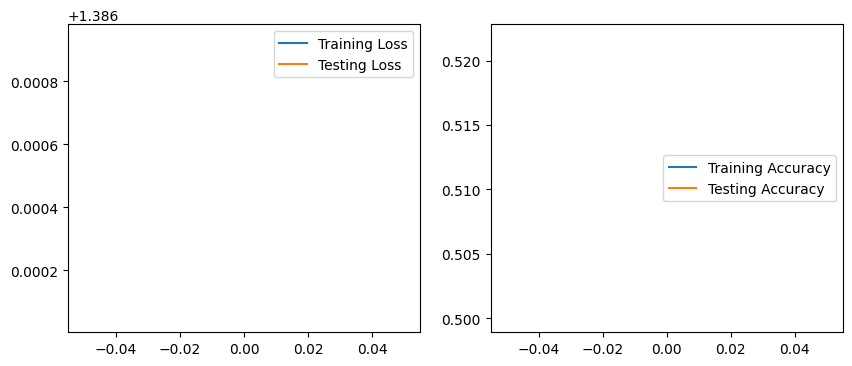

Final Test Accuracy: 0.6901041865348816


In [ ]:

# Load the data
open = np.load("/content/gdrive/My Drive/Research_Paper/Training/normalized-training-open-64ch.npy")
closed = np.load("/content/gdrive/My Drive/Research_Paper/Training/normalized-training-closed-64ch.npy")

predicted_labels_real_classifier, true_labels_real_classifier, netD = train(open, closed)



Epoch 0
Train Loss: 1.3863160610198975 Test Loss: 1.3848800659179688
Train Accuracy: 0.4893616735935211 Test Accuracy: 0.5


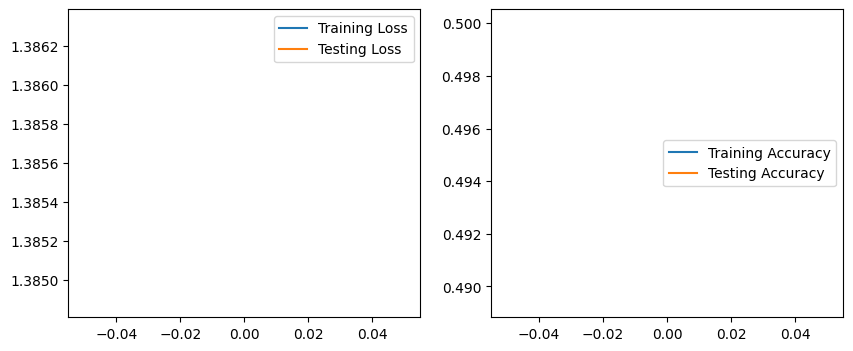

Final Test Accuracy: 0.7599826455116272


In [ ]:
open = np.load("/content/gdrive/My Drive/Research_Paper/Training/normalized-training-open-64ch.npy")
closed = np.load("/content/gdrive/My Drive/Research_Paper/Training/normalized-training-closed-64ch.npy")
open_generated = np.load("/content/gdrive/My Drive/Research_Paper/Generated/64ch-wgan-open-k3-generated1.npy")
closed_generated = np.load("/content/gdrive/My Drive/Research_Paper/Generated/64ch-wgan-cloesd-k3-generated1.npy")

open = np.concatenate((open, open_generated))
closed = np.concatenate((closed, closed_generated))

predicted_labels_synthetic_classifier, true_labels_synthetic_classifier, netD = train(open, closed)



Epoch 0
Train Loss: 1.3862643241882324 Test Loss: 1.385394811630249
Train Accuracy: 0.52173912525177 Test Accuracy: 0.5078125


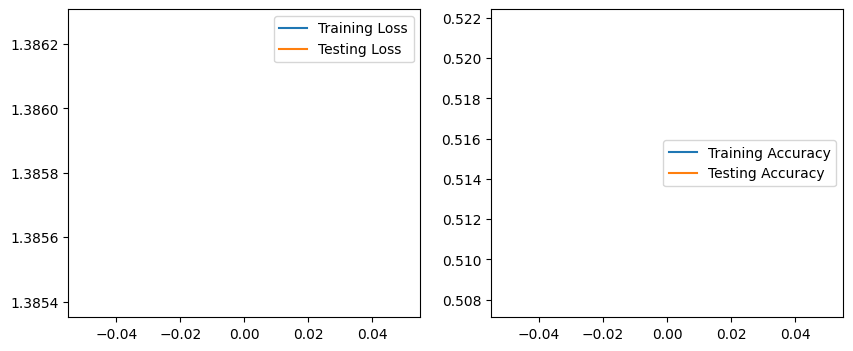

Final Test Accuracy: 0.6597222089767456


In [ ]:
# real data x2
open = np.load("/content/gdrive/My Drive/Research_Paper/Training/normalized-training-open-64ch.npy")
closed = np.load("/content/gdrive/My Drive/Research_Paper/Training/normalized-training-closed-64ch.npy")

predicted_labels_synthetic_classifier, true_labels_synthetic_classifier, netD = train(open, closed, dupe=True)